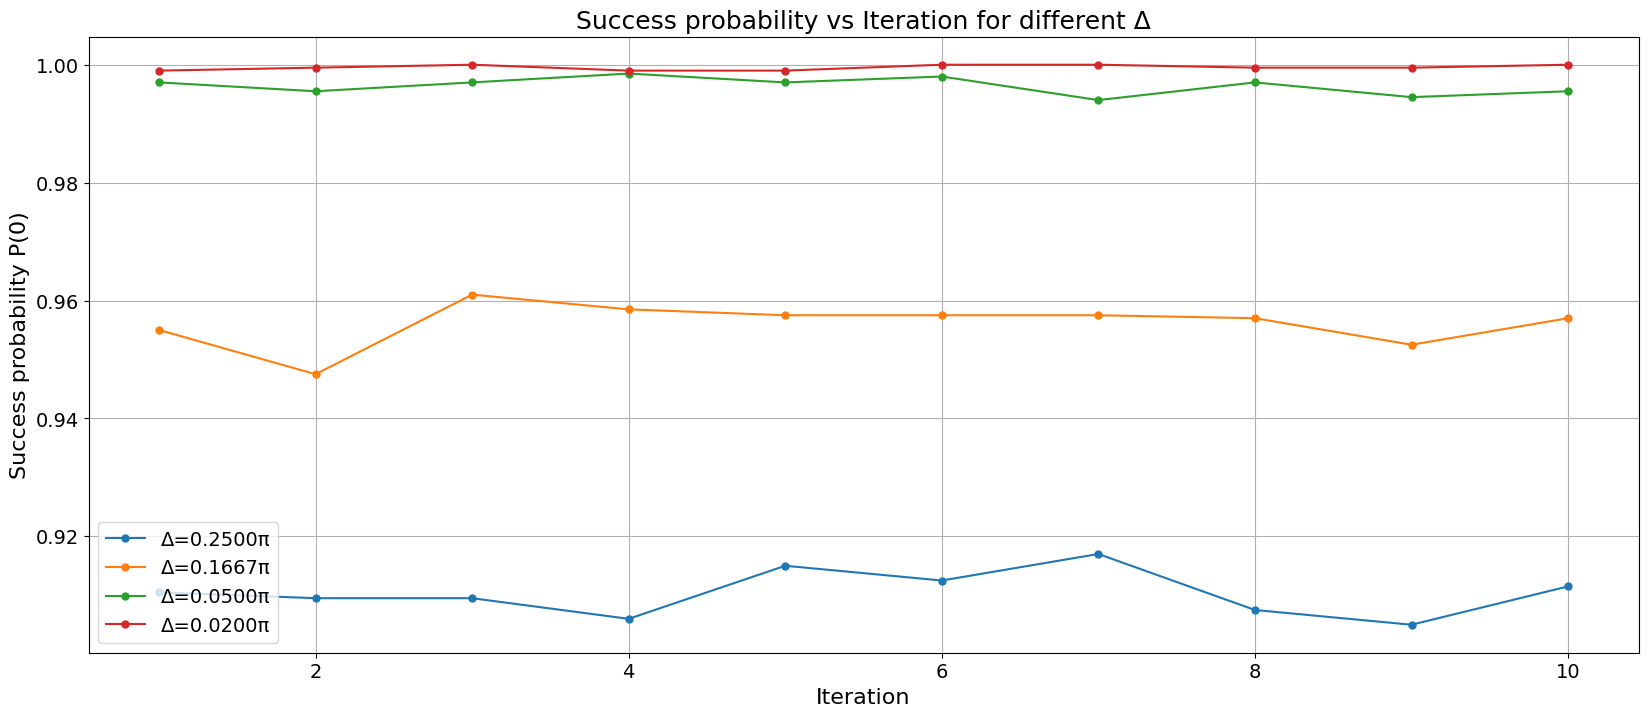

In [6]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3          # number of qubits per register
m = 10         # number of iterations
number_of_layers = 2
shots = 2000

# Pick 4 fixed δ values (as multiples of π)
delta_fractions = [1/4, 1/6, 1/20, 1/50]   # π/4, π/6, π/20, π/50
deltas = [f * np.pi for f in delta_fractions]

# Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

sim = AerSimulator()
success_probs_dict = {}

# ---------------- Function to run one experiment ----------------
def run_experiment(delta):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    # Initialize ψ and φ
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # bit matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # undo matching
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # measure φ
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m-1:
            qc.append(U_phi, phi_reg)

    qc.save_statevector()
    qc_t = transpile(qc.decompose(reps=10), sim, optimization_level=0)
    result = sim.run(qc_t, shots=shots).result()

    # Collect per-iteration success probabilities
    success_probs = []
    for k in range(m):
        indices = list(range(k*n, (k+1)*n))  # clbits for c[k]
        counts_k = marginal_counts(result.get_counts(qc_t), indices)
        zero_state = "0"*n
        success_probs.append(counts_k.get(zero_state, 0) / shots)
    return success_probs

# ---------------- Run experiments for each δ ----------------
for delta in deltas:
    success_probs_dict[delta] = run_experiment(delta)

# ---------------- Plotting ----------------
plt.figure(figsize=(20, 8))
for delta in deltas:
    sim_probs = success_probs_dict[delta]
    plt.plot(range(1, m+1), sim_probs, marker='o', linestyle='-', markersize=5,
             label=f"Δ={delta/np.pi:.4f}π")

plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Success probability P(0)", fontsize=16)
plt.title("Success probability vs Iteration for different Δ", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.3638079012812616
Current number of layers: 0


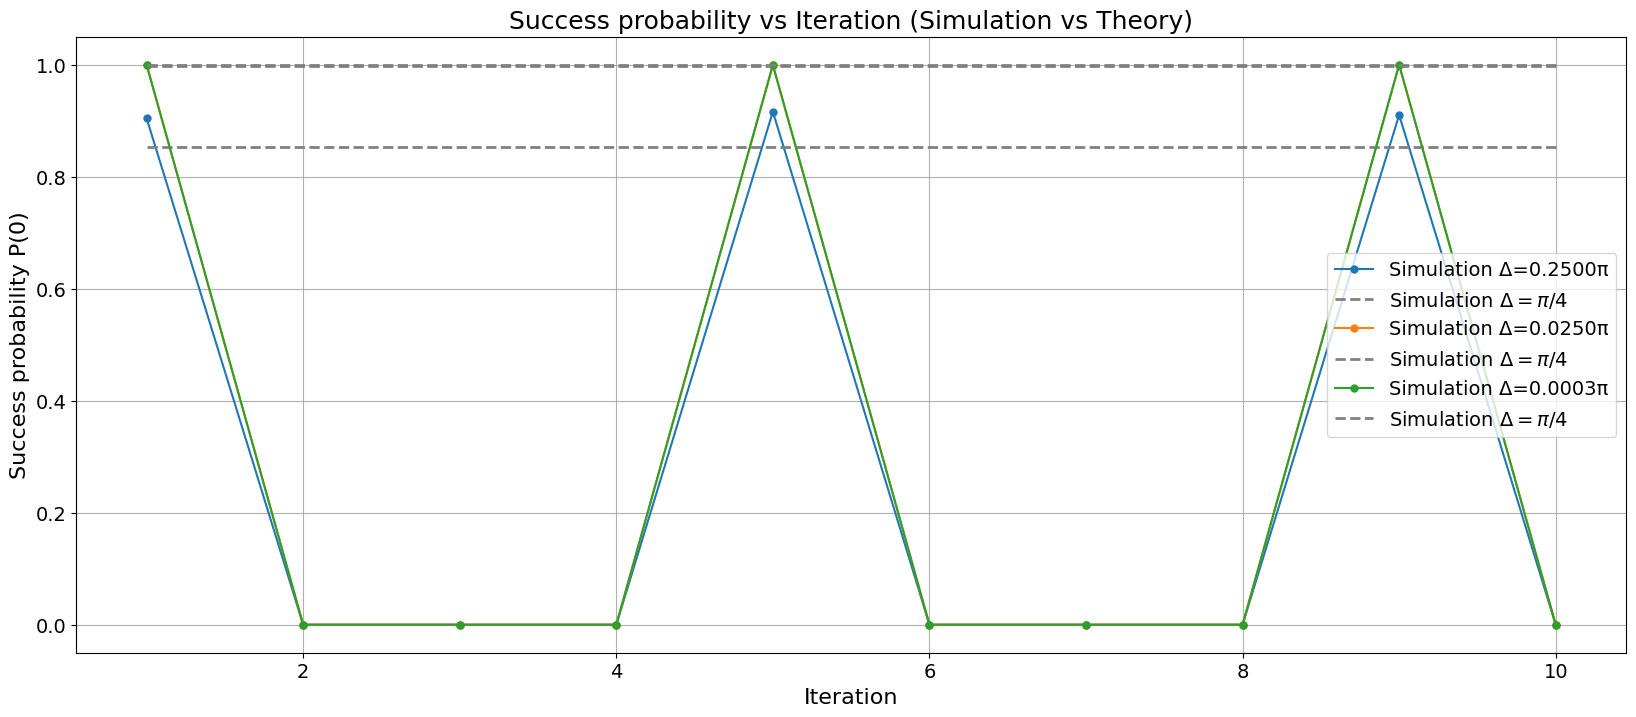

In [46]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3
m = 10
number_of_layers = 2

# Use Δ in multiples of π
delta_fractions = [1/4, 1/40, 1/4000]  # π/4, π/40, π/4000
deltas = [f * np.pi for f in delta_fractions]

# Initialize states
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

# Simulator
sim = AerSimulator()

# Dictionary to store success probabilities
success_probs_dict = {}

# ---------------- Loop over Δ ----------------
for delta in deltas:
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    # Initialize states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # Iterative protocol
    for k in range(m):
        # Bit matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # Controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # Undo matching
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # Measure ancilla
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m-1:
            qc.append(U_phi, phi_reg)

    qc.save_statevector()

    # Run simulation
    qc_t = transpile(qc.decompose(reps=10), sim, optimization_level=0)
    result = sim.run(qc_t).result()
    all_counts = result.get_counts(qc_t)

    # Compute success probability per iteration
    success_probs = []
    for k in range(m):
        success, total = 0, 0
        for bitstring, count in all_counts.items():
            chunks = [bitstring[i:i+n] for i in range(0, len(bitstring), n)]
            chunks = chunks[::-1]
            if chunks[k] == "000":
                success += count
            total += count
        success_probs.append(success / total if total > 0 else 0)

    success_probs_dict[delta] = success_probs

# ---------------- Plotting ----------------
plt.figure(figsize=(20, 8))  # big figure
for delta in deltas:
    sim_probs = success_probs_dict[delta]
    # Simulation: discrete markers
    plt.plot(range(1, m+1), sim_probs, marker='o', linestyle='-', markersize=5, label=f"Simulation Δ={delta/np.pi:.4f}π")

    # Theory: smooth line
    theory_val = 1 - np.sin(delta/2)**2
    plt.hlines(theory_val, 1, m, linestyles='dashed', linewidth=2, colors='gray', label=r"Simulation $\Delta = \pi/4$")

plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Success probability P(0)", fontsize=16)
plt.title("Success probability vs Iteration (Simulation vs Theory)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


/tmp/ipykernel_13335/907388567.py:43: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  if len(state) == 2**(2*n):  # full ψ⊗φ system
/tmp/ipykernel_13335/907388567.py:65: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  full_state = full_state.reshape(dim, dim)


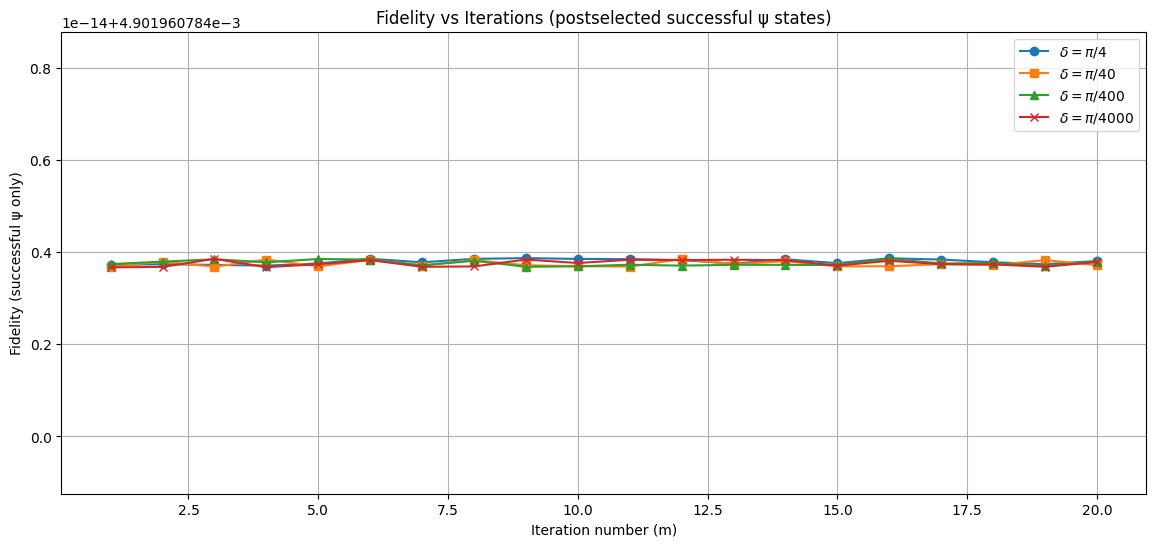

In [2]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 1, 1, 1, 1, 1, 1, 1]
n = 3                      # number of qubits in ψ and φ
number_of_layers = 2
m_values = list(range(1, 21))
delta_values = [np.pi/4, np.pi/40, np.pi/400, np.pi/4000]

# --- Build MPS initializer circuits ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

sim = AerSimulator()

# --- Function: Run protocol for m iterations ---
def run_protocol(m, delta):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    qc = QuantumCircuit(psi_reg, phi_reg)
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)
    qc.save_statevector()
    state = sim.run(transpile(qc, sim)).result().get_statevector(qc)

    fidelities = []

    for k in range(1, m+1):
        psi_reg = QuantumRegister(n, "ψ")
        phi_reg = QuantumRegister(n, "φ")
        qc = QuantumCircuit(psi_reg, phi_reg)

        # --- Initialize depending on whether state is ψ or ψ⊗φ ---
        if len(state) == 2**(2*n):  # full ψ⊗φ system
            qc.initialize(state, psi_reg[:] + phi_reg[:])
        elif len(state) == 2**n:    # only ψ left, reattach φ
            qc.initialize(state, psi_reg)
            qc.append(U_phi, phi_reg)
        else:
            raise ValueError(f"Unexpected state length {len(state)}")

        # --- protocol step ---
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)
        qc.append(U_phi_dagger, phi_reg)
        qc.save_statevector()

        result = sim.run(transpile(qc, sim)).result()
        full_state = result.get_statevector(qc)

        # --- Project φ onto |000⟩ ---
        dim = 2**n
        full_state = full_state.reshape(dim, dim)
        success_component = full_state[:, 0]
        p_success = np.linalg.norm(success_component)**2

        if p_success < 1e-12:
            break

        state = success_component / np.sqrt(p_success)

        # --- Compare fidelity with ideal ψ ---
        psi_vec = np.array(psi) / np.linalg.norm(psi)
        ideal_phase = np.exp(1j * k * delta * np.abs(np.array(phi)/np.linalg.norm(phi))**2)
        ideal_vec = psi_vec * ideal_phase

        fid = state_fidelity(DensityMatrix(state), DensityMatrix(ideal_vec))
        fidelities.append(fid)

    return fidelities


# --- Run for multiple δ values ---
fidelity_dict = {}
for delta_val in delta_values:
    fids = run_protocol(max(m_values), delta_val)
    fidelity_dict[delta_val] = fids

# --- Plot fidelity vs iteration ---
plt.figure(figsize=(14,6))
markers = ['o-', 's-', '^-', 'x-']
labels = [r'$\delta = \pi/4$', r'$\delta = \pi/40$', r'$\delta = \pi/400$', r'$\delta = \pi/4000$']

for delta_val, lbl, mk in zip(delta_values, labels, markers):
    fids = fidelity_dict[delta_val]
    plt.plot(range(1, len(fids)+1), fids, mk, label=lbl)

plt.xlabel("Iteration number (m)")
plt.ylabel("Fidelity (successful ψ only)")
plt.title("Fidelity vs Iterations (postselected successful ψ states)")
plt.grid(True)
plt.legend()
plt.show()
